# Part 2: Shakespeare Pretraining
## Same model, different domain

In Part 1, we built a character-level language model that generates Indian names. Now we'll prove that **the same architecture works on completely different data**.

We'll train on Shakespeare's text and generate new "Shakespeare-like" prose.

## The Key Insight

Language models are **general-purpose pattern learners**. The same architecture that learned:

- Names often start with consonants
- Vowels follow consonants in patterns
- Names end with 'a', 'i', or consonants

Can also learn:

- English words have common letter patterns
- Shakespearean vocabulary and rhythm
- How sentences flow

## Setup

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import os
import requests

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 1: Get Shakespeare's Text

We'll use the "tiny Shakespeare" dataset—a collection of Shakespeare's works.

In [2]:
# Download Shakespeare dataset
if not os.path.exists('shakespeare.txt'):
    print("Downloading Shakespeare dataset...")
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    response = requests.get(url)
    with open('shakespeare.txt', 'w') as f:
        f.write(response.text)
    print("Download complete!")

with open('shakespeare.txt', 'r') as f:
    text = f.read()

print(f"Total characters: {len(text):,}")
print(f"\nFirst 500 characters:")
print("-" * 50)
print(text[:500])

Download complete!
Total characters: 1,115,394

First 500 characters:
--------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [3]:
# Look at the character set
chars = sorted(set(text))
print(f"Unique characters: {len(chars)}")
print(f"Characters: {''.join(chars)}")

Unique characters: 65
Characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


## Step 2: Build Vocabulary

Notice the vocabulary is different from names:

- Uppercase and lowercase letters
- Punctuation marks
- Newlines and spaces

In [4]:
# Create mappings
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

vocab_size = len(stoi)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 65


## Step 3: Create Training Data

Same approach as Part 1, but now we slide a window over continuous text rather than individual words.

In [5]:
block_size = 32  # Larger context for prose

def build_dataset(text, stoi, block_size):
    """
    Create training examples from continuous text.
    
    Unlike names, we don't have natural boundaries.
    We just slide a window over the entire text.
    """
    X, Y = [], []
    
    for i in range(len(text) - block_size):
        context = text[i:i + block_size]
        target = text[i + block_size]
        
        X.append([stoi[ch] for ch in context])
        Y.append(stoi[target])
    
    return torch.tensor(X), torch.tensor(Y)

X, Y = build_dataset(text, stoi, block_size)
print(f"Dataset size: {len(X):,} examples")
print(f"Input shape: {X.shape}")
print(f"Target shape: {Y.shape}")

Dataset size: 1,115,362 examples
Input shape: torch.Size([1115362, 32])
Target shape: torch.Size([1115362])


In [6]:
# Visualize some examples
print("Sample training examples:")
print("-" * 60)
for i in range(0, 15, 5):
    context = ''.join(itos[idx.item()] for idx in X[i])
    target = itos[Y[i].item()]
    # Show context with target highlighted
    print(f"'{context}' → '{target}'")

Sample training examples:
------------------------------------------------------------
'First Citizen:
Before we proceed' → ' '
' Citizen:
Before we proceed any ' → 'f'
'zen:
Before we proceed any furth' → 'e'


## Step 4: The Same Model

Here's the crucial point: **we use the exact same architecture** from Part 1.

In [7]:
class CharLM(nn.Module):
    """Same architecture as Part 1!"""
    
    def __init__(self, vocab_size, block_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.hidden = nn.Linear(block_size * emb_dim, hidden_size)
        self.output = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = torch.tanh(self.hidden(x))
        x = self.output(x)
        return x

In [ ]:
# Create model with larger capacity for more complex data
emb_dim = 32   # Increased from 16
hidden_size = 512  # Increased from 256

model = CharLM(vocab_size, block_size, emb_dim, hidden_size).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {num_params:,} parameters")

# Model scale context
print(f"\n--- Model Scale Context ---")
print(f"Our model:     ~{num_params/1000:.0f}K parameters")
print(f"GPT-2 Small:   124M parameters  ({124_000_000/num_params:.0f}x larger)")
print(f"GPT-3:         175B parameters  ({175_000_000_000/num_params:.0f}x larger)")
print(f"Claude/GPT-4:  ~1T+ parameters  ({1_000_000_000_000/num_params:.0f}x larger)")

### Model Scaling

Compared to Part 1:
- **Names model**: ~5,000 parameters
- **Shakespeare model**: ~50,000+ parameters

We scaled up because:
1. Larger vocabulary (65 vs 27)
2. Longer context (32 vs 5)
3. More complex patterns to learn

## Step 5: Train

In [9]:
def train(model, X, Y, epochs=1000, batch_size=2048, lr=0.001):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    X, Y = X.to(device), Y.to(device)
    losses = []
    
    for epoch in range(epochs):
        perm = torch.randperm(X.shape[0])
        total_loss = 0
        n_batches = 0
        
        for i in range(0, X.shape[0], batch_size):
            idx = perm[i:i+batch_size]
            x_batch, y_batch = X[idx], Y[idx]
            
            logits = model(x_batch)
            loss = loss_fn(logits, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            n_batches += 1
        
        avg_loss = total_loss / n_batches
        losses.append(avg_loss)
        
        if epoch % 200 == 0:
            print(f"Epoch {epoch:4d} | Loss: {avg_loss:.4f}")
    
    return losses

losses = train(model, X, Y, epochs=1000, batch_size=4096, lr=0.003)

Epoch    0 | Loss: 2.3469
Epoch  200 | Loss: 1.4234
Epoch  400 | Loss: 1.4157
Epoch  600 | Loss: 1.4120
Epoch  800 | Loss: 1.4108


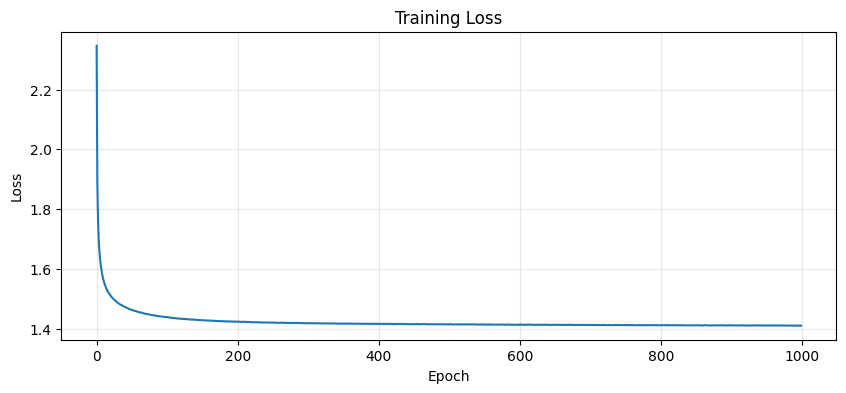

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

## Step 6: Generate Shakespeare!

In [11]:
@torch.no_grad()
def generate(model, itos, stoi, block_size, seed_text=None, length=500, temperature=0.8):
    """Generate text character by character."""
    model.eval()
    
    # Start with seed text or random text from vocabulary
    if seed_text is None:
        seed_text = "ROMEO:\n"
    
    # Pad seed text to block_size
    if len(seed_text) < block_size:
        seed_text = " " * (block_size - len(seed_text)) + seed_text
    elif len(seed_text) > block_size:
        seed_text = seed_text[-block_size:]
    
    context = [stoi.get(ch, 0) for ch in seed_text]
    generated = list(seed_text)
    
    for _ in range(length):
        x = torch.tensor([context]).to(device)
        logits = model(x)
        probs = F.softmax(logits / temperature, dim=-1)
        next_idx = torch.multinomial(probs, 1).item()
        next_char = itos[next_idx]
        
        generated.append(next_char)
        context = context[1:] + [next_idx]
    
    return ''.join(generated)

In [12]:
print("=" * 60)
print("GENERATED SHAKESPEARE (temperature=0.8)")
print("=" * 60)
print(generate(model, itos, stoi, block_size, "ROMEO:\n", length=800, temperature=0.8))

GENERATED SHAKESPEARE (temperature=0.8)
                         ROMEO:
It, no monted in news to a modds and heard:
There of the comminess appiitted we have greated the stacours,
God in deall compation. What's that saw thy hand;
For we flock the sea judger: which
un remorn a words us a gentlemen?
To someton'd my homent: and would have thee is dest: I will be the down:
This wate be represend what persue to my son,
And there will not so doo the barthenselions
To his dunes us now his served:
The Duke of March my father ageds:
I wordship this sact more be sate?
The is the senter of mine; do' there, for a worsesy have doth wholds
Insolves now a call. And down too, how
Have not the faced by a sweet so,
With perit, and then in pluck acceami less me
A crowned om your coulcuse assurous bed;
And life day I could not gentleman
With his and mincest rodits of my lord.

DUK


In [13]:
print("=" * 60)
print("GENERATED SHAKESPEARE (temperature=0.5, more focused)")
print("=" * 60)
print(generate(model, itos, stoi, block_size, "To be or not to be", length=500, temperature=0.5))

GENERATED SHAKESPEARE (temperature=0.5, more focused)
              To be or not to betime
To the maid perse is the comping.

PETRUCHIO:
I would not shall meet.

MENENIUS:
What mady to courted confess I shall the world.

GLOUCESTER:
And his some to my old excounters
Are other since the son the common the see
the will this smitius when the matter?

VOLUMNIA:
He commosed, my heart!

BRUTUS:
Why should speak to their dead more,
And where is was she become his own than is to point her fortune to the deep
yourself news thee speaks to strike?

MENENIUS:
Pray you shame share!
And stings


## Comparing Names vs Shakespeare

Let's see how the same architecture adapts to different domains:

| Aspect | Names Model | Shakespeare Model |
|--------|-------------|-------------------|
| Vocabulary | 27 (a-z + '.') | 65 (mixed case + punctuation) |
| Context | 5 characters | 32 characters |
| Pattern type | Word structure | Prose flow |
| Output | Single words | Continuous text |
| Parameters | ~5K | ~50K |

### The Universal Pattern

Both models learn the same fundamental task:

**P(next character | previous characters)**

The architecture doesn't change. Only the data and scale differ. This is exactly how large language models work—they're just scaled up versions of what we built here.

## Visualizing Embeddings

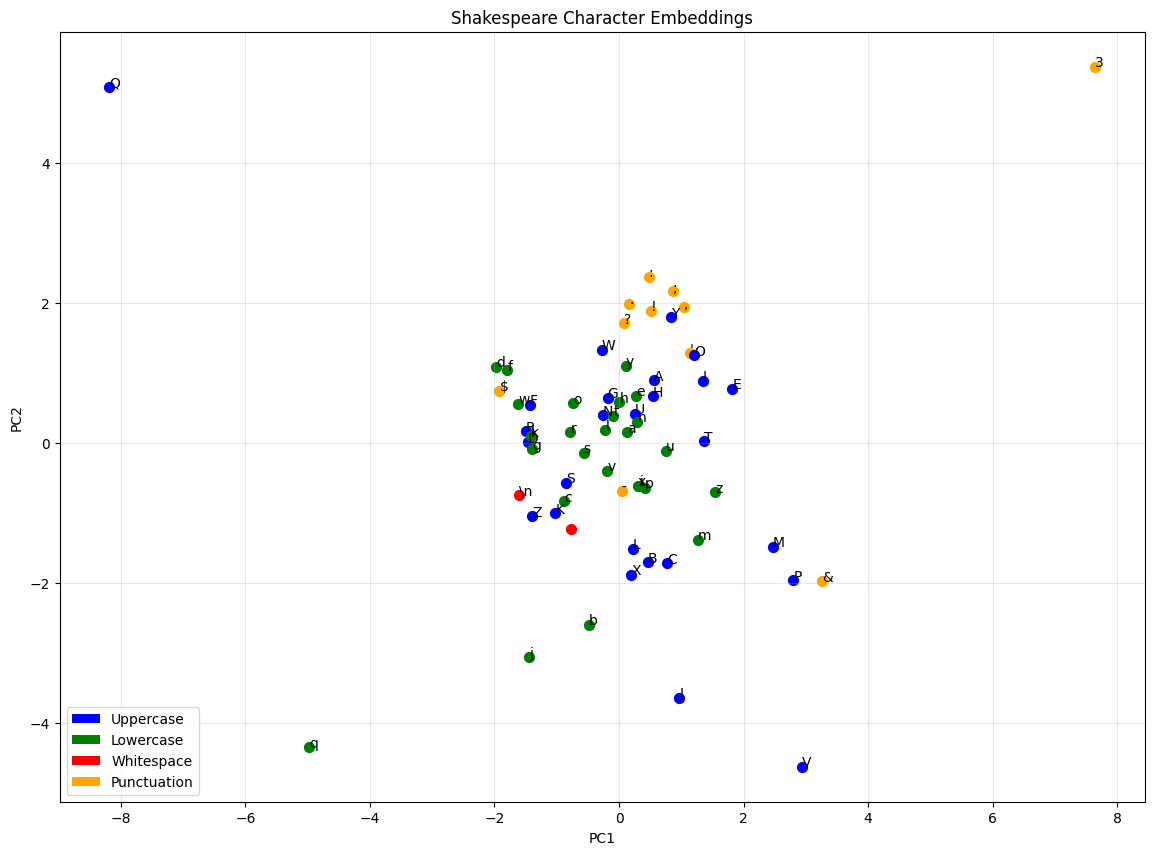

In [14]:
from sklearn.decomposition import PCA

def plot_embeddings(model, itos, highlight_chars=None):
    weights = model.emb.weight.detach().cpu().numpy()
    
    pca = PCA(n_components=2)
    weights_2d = pca.fit_transform(weights)
    
    plt.figure(figsize=(14, 10))
    
    for i, (x, y) in enumerate(weights_2d):
        char = itos[i]
        # Color code by character type
        if char.isalpha() and char.isupper():
            color = 'blue'
        elif char.isalpha() and char.islower():
            color = 'green'
        elif char.isspace() or char == '\n':
            color = 'red'
        else:
            color = 'orange'
        
        plt.scatter(x, y, c=color, s=50)
        # Show printable chars, escape others
        label = char if char.isprintable() and not char.isspace() else repr(char)[1:-1]
        plt.annotate(label, (x, y), fontsize=10)
    
    plt.title('Shakespeare Character Embeddings')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', label='Uppercase'),
        Patch(facecolor='green', label='Lowercase'),
        Patch(facecolor='red', label='Whitespace'),
        Patch(facecolor='orange', label='Punctuation')
    ]
    plt.legend(handles=legend_elements)
    plt.show()

plot_embeddings(model, itos)

## Save Model for Later Use

Export the Shakespeare model for comparison with BPE and for use in applications.

In [ ]:
import os

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save model checkpoint with all necessary info for inference
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'vocab_size': vocab_size,
        'block_size': block_size,
        'emb_dim': emb_dim,
        'hidden_size': hidden_size,
    },
    'stoi': stoi,
    'itos': itos,
    'final_loss': losses[-1] if losses else None,
}

torch.save(checkpoint, '../models/char_lm_shakespeare.pt')
print(f"Model saved to ../models/char_lm_shakespeare.pt")

# Verify the checkpoint
loaded = torch.load('../models/char_lm_shakespeare.pt', weights_only=False)
print(f"Checkpoint keys: {list(loaded.keys())}")
print(f"Model config: {loaded['model_config']}")
print(f"Final training loss: {loaded['final_loss']:.4f}")

## Clean Up GPU Memory

In [ ]:
import gc

# Delete model and data tensors
del model
del X, Y

# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

gc.collect()

print("GPU memory cleared!")
if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")

## The Limitation: Character-Level

Our model works, but it has a fundamental limitation: **it sees characters, not words**.

When predicting the next character after "The king", our model must:
1. Remember that 'T-h-e- -k-i-n-g' was seen
2. Predict what comes next one character at a time

This is inefficient. Consider:
- To learn "the", it needs "t→h", "h→e", "e→ " patterns
- To learn "thee" (Shakespearean), it needs different patterns
- No concept of words as units

### Preview of Part 3

In Part 3, we'll introduce **Byte-Pair Encoding (BPE)**, which learns to tokenize at the subword level:

- Common words become single tokens: "the" → [token_123]
- Rare words split into pieces: "shakespeare" → ["shake", "speare"]

This is how GPT-2, GPT-3, and modern LLMs tokenize text.

## Summary

We demonstrated that our character-level language model is **domain-agnostic**:

1. Same architecture works on names and Shakespeare
2. Only data and hyperparameters change
3. The model learns whatever patterns exist in the data

This is the power of neural language models—they're universal pattern learners.

## What's Next

In **Part 3**, we'll build a **BPE tokenizer from scratch** and show how subword tokenization improves model quality and efficiency.

## Exercises

1. **Different prompts**: Try generating from "HAMLET:", "JULIET:", "First Citizen:"
2. **Context length**: What happens with block_size = 8 vs 64?
3. **Temperature exploration**: Generate at temperatures 0.2, 0.5, 1.0, 1.5
4. **Train longer**: What's the minimum loss you can achieve?
5. **Measure perplexity**: Compute exp(loss) on held-out text